In [1]:
!pip install torch transformers 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 11.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [3]:
### Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, average_precision_score
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

In [4]:
#Load train and test files

train =  pd.read_table('medisyn-labs/train.tsv',sep='\t', header=None)
test = pd.read_table('medisyn-labs/test.tsv',sep='\t', header=None)

In [5]:
train.head()

,0,1,2,3,4,5,6,7,8
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [6]:
### Adding headers to train and test files
train.columns = ['Customer_Identifier','Medicine_Name','Rating','Effectiveness','Side_Effects','Condition','Benefit_Review','Side_Effect_Review','Overall_Review']
test.columns = ['Customer_Identifier','Medicine_Name','Rating','Effectiveness','Side_Effects','Condition','Benefit_Review','Side_Effect_Review','Overall_Review']

In [7]:
train.head(5)

,Customer_Identifier,Medicine_Name,Rating,Effectiveness,Side_Effects,Condition,Benefit_Review,Side_Effect_Review,Overall_Review
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [8]:
test.head(2)

,Customer_Identifier,Medicine_Name,Rating,Effectiveness,Side_Effects,Condition,Benefit_Review,Side_Effect_Review,Overall_Review
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...


In [9]:
# Number of rows and cols in train and test set
print("The dimensions of training data is {}".format(train.shape))
print("The dimensions of testing data is {}".format(test.shape))

The dimensions of training data is (3107, 9)
The dimensions of testing data is (1036, 9)


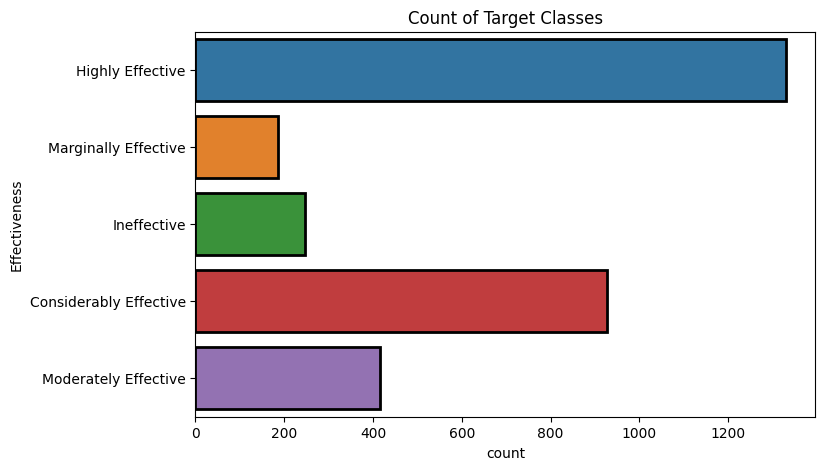

In [10]:
# Visualizing the Effectivess Rating
plt.figure(figsize=(8,5))
plt.title("Count of Target Classes")
sns.countplot(y=train["Effectiveness"],linewidth=2,
                   edgecolor='black')

plt.show()

In [11]:
## Converting effectiveness labels into rating on scale of 1-5
train['Effectiveness_Rating'] = train['Effectiveness'].map({'Highly Effective':1,'Considerably Effective':2,'Moderately Effective':3,
                                                           'Marginally Effective':4,'Ineffective':5})
test['Effectiveness_Rating'] = test['Effectiveness'].map({'Highly Effective':1,'Considerably Effective':2,'Moderately Effective':3,
                                                           'Marginally Effective':4,'Ineffective':5})

In [12]:
train.head(2)

,Customer_Identifier,Medicine_Name,Rating,Effectiveness,Side_Effects,Condition,Benefit_Review,Side_Effect_Review,Overall_Review,Effectiveness_Rating
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",1
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",1


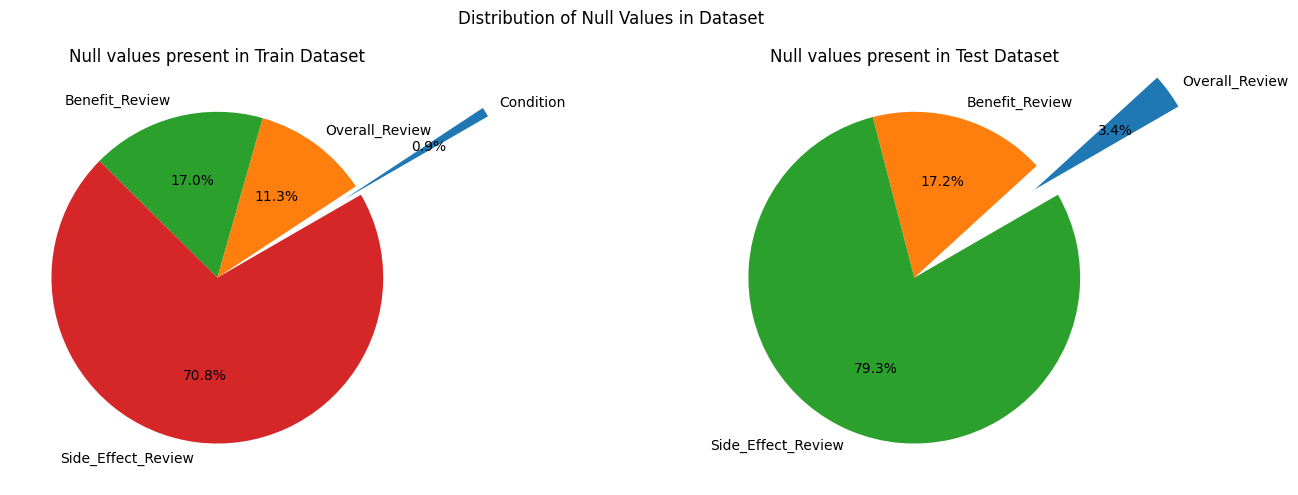

In [13]:
# Checking Null values
missing_train = train.isnull().sum()  
missing_test = test.isnull().sum()  
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
missing_train = missing_train[missing_train>0].sort_values()
ax1.pie(missing_train,autopct='%1.1f%%',startangle=30,explode=[0.9,0,0,0],labels=['Condition', 'Overall_Review', 'Benefit_Review','Side_Effect_Review'])
ax1.set_title("Null values present in Train Dataset")

missing_test = missing_test[missing_test>0].sort_values()
ax2.pie(missing_test,autopct='%1.1f%%',startangle=30,explode=[0.9,0,0],labels=['Overall_Review', 'Benefit_Review','Side_Effect_Review'])
ax2.set_title("Null values present in Test Dataset")
plt.suptitle("Distribution of Null Values in Dataset")
plt.tight_layout()
plt.show()

In [14]:
train.isnull().sum()

Customer_Identifier      0
Medicine_Name            0
Rating                   0
Effectiveness            0
Side_Effects             0
Condition                1
Benefit_Review          18
Side_Effect_Review      75
Overall_Review          12
Effectiveness_Rating     0
dtype: int64

In [13]:
## Text cleaning
def preprocess_data(data):
    if pd.isnull(data)==True:
        return
    else:
        review = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) #removal of url
        review = re.sub(r'[^a-zA-Z0-9\s]', '', review) # filtering out miscellaneous text.
        review = review.lower() # Lowering all the words in text
    return review

train["cleaned_overall_review"] = train["Overall_Review"].apply(preprocess_data)
train["cleaned_condition"] = train["Condition"].apply(preprocess_data)
train["cleaned_benefit_review"] = train["Benefit_Review"].apply(preprocess_data)
train["cleaned_side_effect_review"] = train["Side_Effect_Review"].apply(preprocess_data)

test["cleaned_overall_review"] = test["Overall_Review"].apply(preprocess_data)
test["cleaned_benefit_review"] = test["Benefit_Review"].apply(preprocess_data)
test["cleaned_side_effect_review"] = test["Side_Effect_Review"].apply(preprocess_data)
test["cleaned_condition"] = test["Condition"].apply(preprocess_data)

In [14]:
train.head()

,Customer_Identifier,Medicine_Name,Rating,Effectiveness,Side_Effects,Condition,Benefit_Review,Side_Effect_Review,Overall_Review,Effectiveness_Rating,cleaned_overall_review,cleaned_condition,cleaned_benefit_review,cleaned_side_effect_review
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",1,monitor blood pressure weight and asses for r...,management of congestive heart failure,slowed the progression of left ventricular dys...,cough hypotension proteinuria impotence rena...
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",1,i hate this birth control i would not suggest ...,birth prevention,although this type of birth control has more c...,heavy cycle cramps hot flashes fatigue long la...
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,1,i took 2 pills at the onset of my menstrual cr...,menstrual cramps,i was used to having cramps so badly that they...,heavier bleeding and clotting than normal
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,4,i was given prilosec prescription at a dose of...,acid reflux,the acid reflux went away for a few months aft...,constipation dry mouth and some mild dizziness...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,4,see above,fibromyalgia,i think that the lyrica was starting to help w...,i felt extremely drugged and dopey could not ...


In [17]:
#Calculate less important words
less_imp_words_overall_review = train[train["cleaned_overall_review"].str.len() <= 10]['cleaned_overall_review']
less_imp_words_benefits_review = train[train["cleaned_benefit_review"].str.len() <= 10]['cleaned_benefit_review']
less_imp_words_side_effects_review = train[train["cleaned_side_effect_review"].str.len() <= 10]['cleaned_side_effect_review']
less_imp_words_condition = train[train["cleaned_condition"].str.len() <= 10]['cleaned_condition']

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


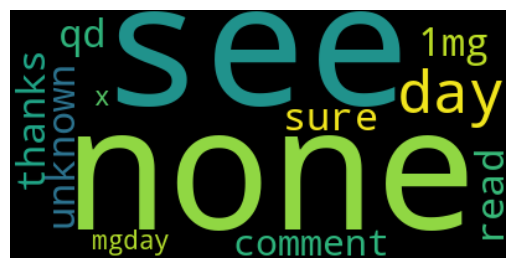

In [18]:
# Analysing common words less important words in Overall Review using WordCloud 

wc = WordCloud(background_color='black')
wc.generate(' '.join(less_imp_words_overall_review))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


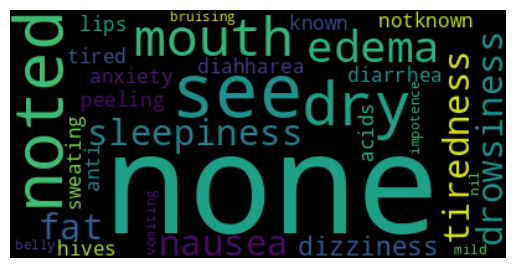

In [19]:
# Analysing common words less important words in Side Effects Review using WordCloud 

wc = WordCloud(background_color='black')
wc.generate(' '.join(less_imp_words_side_effects_review))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


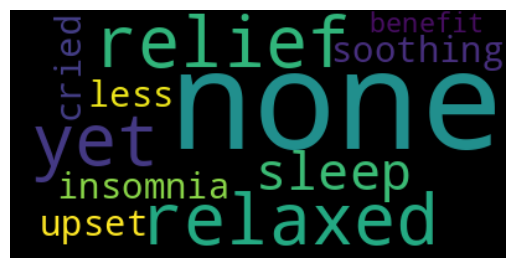

In [20]:
# Analysing common words less important words in Benefits Review using WordCloud 

wc = WordCloud(background_color='black')
wc.generate(' '.join(less_imp_words_benefits_review))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


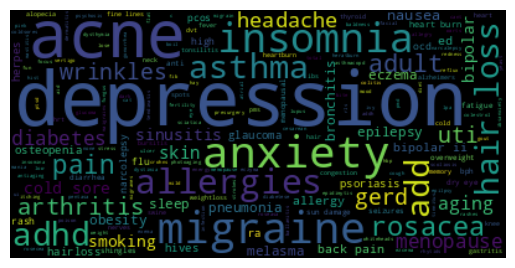

In [21]:
# Analysing common words less important words in Condition Name using WordCloud 

wc = WordCloud(background_color='black')
wc.generate(' '.join(less_imp_words_condition))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


In [15]:
### Replace 'see above'
train['cleaned_overall_review'] = np.where(train['cleaned_overall_review'].str.contains("see above"), train['cleaned_overall_review'].shift(1), train['cleaned_overall_review'])
train['cleaned_side_effect_review'] = np.where(train['cleaned_side_effect_review'].str.contains("see above"), train['cleaned_side_effect_review'].shift(1), train['cleaned_side_effect_review'])

test['cleaned_overall_review'] = np.where(test['cleaned_overall_review'].str.contains("see above"), test['cleaned_overall_review'].shift(1), test['cleaned_overall_review'])
test['cleaned_side_effect_review'] = np.where(test['cleaned_side_effect_review'].str.contains("see above"), test['cleaned_side_effect_review'].shift(1), test['cleaned_side_effect_review'])
## Dropping sequences having length less than 10  #3095
train['cleaned_overall_review'] = np.where(train["cleaned_overall_review"].str.len() <= 10,'',train["cleaned_overall_review"])
train['cleaned_side_effect_review'] = np.where(train["cleaned_side_effect_review"].str.len() <= 5,'',train["cleaned_side_effect_review"])
train['cleaned_benefit_review'] = np.where(train["cleaned_benefit_review"].str.len() <= 5,'',train["cleaned_benefit_review"])
train['cleaned_condition'] = np.where(train["cleaned_condition"].str.len() <= 5,'',train["cleaned_condition"])


test['cleaned_overall_review'] = np.where(test["cleaned_overall_review"].str.len() <= 10,'',test["cleaned_overall_review"])
test['cleaned_side_effect_review'] = np.where(test["cleaned_side_effect_review"].str.len() <= 5,'',test["cleaned_side_effect_review"])
test['cleaned_benefit_review'] = np.where(test["cleaned_benefit_review"].str.len() <= 5,'',test["cleaned_benefit_review"])
test['cleaned_condition'] = np.where(test["cleaned_condition"].str.len() <= 5,'',test["cleaned_condition"])


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [16]:
train.head()

,Customer_Identifier,Medicine_Name,Rating,Effectiveness,Side_Effects,Condition,Benefit_Review,Side_Effect_Review,Overall_Review,Effectiveness_Rating,cleaned_overall_review,cleaned_condition,cleaned_benefit_review,cleaned_side_effect_review
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",1,monitor blood pressure weight and asses for r...,management of congestive heart failure,slowed the progression of left ventricular dys...,cough hypotension proteinuria impotence rena...
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",1,i hate this birth control i would not suggest ...,birth prevention,although this type of birth control has more c...,heavy cycle cramps hot flashes fatigue long la...
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,1,i took 2 pills at the onset of my menstrual cr...,menstrual cramps,i was used to having cramps so badly that they...,heavier bleeding and clotting than normal
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,4,i was given prilosec prescription at a dose of...,acid reflux,the acid reflux went away for a few months aft...,constipation dry mouth and some mild dizziness...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,4,i was given prilosec prescription at a dose of...,fibromyalgia,i think that the lyrica was starting to help w...,i felt extremely drugged and dopey could not ...


In [17]:
#Concatenate the features into one feature-> Cleaned_Review

train['cleaned_review'] = train['cleaned_overall_review'].fillna('')+ ' '+train['cleaned_benefit_review'].fillna('')+' '+ train['cleaned_side_effect_review'].fillna('')+' '+train['cleaned_condition'].fillna('')+' '+train['Medicine_Name']
test['cleaned_review'] = test['cleaned_overall_review'].fillna('')+ ' '+ test['cleaned_benefit_review'].fillna('')+' '+ test['cleaned_side_effect_review'].fillna('')+' '+test['cleaned_condition'].fillna('')+' '+test['Medicine_Name']


In [18]:
#Copy the contents in new variables
train_dropped = train.copy()
test_dropped =  test.copy()

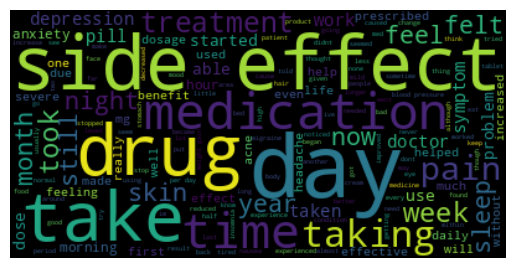

In [19]:
# Analysing common words in cleaned review using WordCloud 

wc = WordCloud(background_color='black')
wc.generate(' '.join(train_dropped['cleaned_review']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


In [20]:
#Segregating train and test variables
x_train = train_dropped[['cleaned_review']]
y_train = train_dropped[['Effectiveness_Rating']]
x_test = test_dropped[['cleaned_review']]
y_test = test_dropped[['Effectiveness_Rating']]

In [28]:
# Using tf-idf embeddings
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
x_train_tranformed = tfidf_vectorizer.fit_transform(x_train['cleaned_review'])
x_test_tranformed = tfidf_vectorizer.transform(x_test['cleaned_review'])

In [29]:
x_train_tranformed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 563884 stored elements and shape (3107, 154871)>

In [30]:
# Model Dev. Using logistic regression
logistic_model = LogisticRegression(random_state=42,class_weight='balanced',multi_class="multinomial")
logistic_model.fit(x_train_tranformed, y_train)
y_pred = logistic_model.predict(x_test_tranformed)
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           1       0.55      0.64      0.59       411
           2       0.41      0.42      0.41       310
           3       0.27      0.18      0.22       157
           4       0.40      0.18      0.25        76
           5       0.39      0.48      0.43        82

    accuracy                           0.46      1036
   macro avg       0.40      0.38      0.38      1036
weighted avg       0.44      0.46      0.44      1036



In [31]:
# Model Dev. Using Naive Bayes

nb_model = MultinomialNB()
nb_model.fit(x_train_tranformed, y_train)
y_pred_nb = nb_model.predict(x_test_tranformed)
print("Classification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           1       0.40      1.00      0.57       411
           2       1.00      0.00      0.01       310
           3       0.00      0.00      0.00       157
           4       0.00      0.00      0.00        76
           5       0.00      0.00      0.00        82

    accuracy                           0.40      1036
   macro avg       0.28      0.20      0.11      1036
weighted avg       0.46      0.40      0.23      1036



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precisio

In [32]:
# Model Dev. Using Random Forest

print("\n--- Random Forest Classifier ---")
rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')
rf_model.fit(x_train_tranformed, y_train)
y_pred_rf = rf_model.predict(x_test_tranformed)
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))


--- Random Forest Classifier ---


/tmp/ipykernel_48/3997640801.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x_train_tranformed, y_train)


Classification Report (Random Forest):
              precision    recall  f1-score   support

           1       0.42      0.94      0.58       411
           2       0.47      0.17      0.25       310
           3       1.00      0.05      0.10       157
           4       0.00      0.00      0.00        76
           5       1.00      0.01      0.02        82

    accuracy                           0.43      1036
   macro avg       0.58      0.23      0.19      1036
weighted avg       0.54      0.43      0.32      1036



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Model Dev.  Pre-Trained BERT Model
y_train_label = y_train['Effectiveness_Rating'].apply(lambda x: x-1)
y_test_label = y_test['Effectiveness_Rating'].apply(lambda x: x-1)
#Tokenizer and encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class Effectivess_Dataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len=280):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        text = self.reviews[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
train_dataset = Effectivess_Dataset(x_train['cleaned_review'], y_train_label, tokenizer)
test_dataset = Effectivess_Dataset(x_test['cleaned_review'], y_test_label, tokenizer)

In [26]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_label),
    y=y_train_label
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")
# Custom loss function with class weights
def custom_loss_fn(outputs, labels):
    logits = outputs.logits
    loss_fct = nn.CrossEntropyLoss(weight=class_weights)
    return loss_fct(logits, labels)

# Custom Trainer class to override loss computation
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        logits = outputs.logits
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # Standard metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    # PR-AUC (macro average)
    try:
        y_true = np.eye(model.config.num_labels)[labels]
        y_score = torch.softmax(torch.tensor(logits), dim=1).numpy()
        pr_auc = average_precision_score(y_true, y_score, average="macro")
    except Exception:
        pr_auc = 0.0  # fallback if computation fails

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "pr_auc": pr_auc}


In [29]:
#Load pre-trained BERT for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.001,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",  
    disable_tqdm=False  
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Initialize weighted trainer
trainer = WeightedTrainer(
    model=model.to("cuda"),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Pr Auc
1,1.594100,1.575547,0.363900,0.340746,0.363900,0.323838,0.292257
2,1.340900,1.435859,0.443050,0.450472,0.443050,0.422826,0.394073
3,1.102600,1.303643,0.471042,0.491488,0.471042,0.461156,0.447996
4,0.967400,1.464011,0.475869,0.492407,0.475869,0.481220,0.439195
5,0.789300,1.484010,0.463320,0.500706,0.463320,0.471325,0.446249
6,0.656300,1.693280,0.487452,0.486113,0.487452,0.483059,0.443795
7,0.655200,1.591180,0.485521,0.511269,0.485521,0.494366,0.443136
8,0.537800,1.626348,0.496139,0.511321,0.496139,0.501209,0.444082


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=784, training_loss=0.9696738324603256, metrics={'train_runtime': 908.9549, 'train_samples_per_second': 27.346, 'train_steps_per_second': 0.863, 'total_flos': 3576597800280960.0, 'train_loss': 0.9696738324603256, 'epoch': 8.0})

In [31]:
# perform inference
test_loader = DataLoader(test_dataset, batch_size=2)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to("cuda")
        attention_mask = batch['attention_mask'].to("cuda")
        labels = batch['labels'].to("cuda")

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [32]:
## Mterics for evaluation
print("Classification Report For BERT:")
label_map = {0: "Highly Effective", 1: "Considerably Effective",2:'Moderately Effective',3:'Marginally Effective',4:'Ineffective'}
# Convert numeric labels back to text
all_labels = [label_map[i] for i in all_labels]
all_preds = [label_map[i] for i in all_preds]
print(classification_report(all_labels, all_preds,target_names=["Highly Effective",'Considerably Effective','Moderately Effective','Marginally Effective','Ineffective']))

Classification Report For BERT:
                        precision    recall  f1-score   support

      Highly Effective       0.45      0.45      0.45       310
Considerably Effective       0.64      0.61      0.62       411
  Moderately Effective       0.65      0.44      0.53        82
  Marginally Effective       0.27      0.32      0.29        76
           Ineffective       0.34      0.41      0.37       157

              accuracy                           0.50      1036
             macro avg       0.47      0.44      0.45      1036
          weighted avg       0.51      0.50      0.50      1036



In [33]:
### Summary table of models
weighted_avg_fscore_1 = 0.44
weighted_avg_fscore_2 = 0.23
weighted_avg_fscore_3 = 0.32
weighted_avg_fscore_4 = 0.50

results = pd.DataFrame([["Logistic Regression",weighted_avg_fscore_1],["Naive Bayes",weighted_avg_fscore_2],["Random Forest",weighted_avg_fscore_3],
                       ["Pre-Trained BERT",weighted_avg_fscore_4]],columns = ["Models","Weighted Avg F1 Score"]).sort_values(by='Weighted Avg F1 Score',ascending=False)
results.style.background_gradient(cmap='Blues')

,Models,Weighted Avg F1 Score
3,Pre-Trained BERT,0.500000
0,Logistic Regression,0.440000
2,Random Forest,0.320000
1,Naive Bayes,0.230000
